In [24]:
import os
import tensorflow.compat.v1 as tf1

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
session = tf1.Session(config=config)

2024-05-27 04:10:07.997241: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4033 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:86:00.0, compute capability: 8.0


# 2. 뇌 이미지들 군집 나누기


In [25]:
import os
print(os.environ["CUDA_VISIBLE_DEVICES"])


2


In [26]:
import os
import numpy as np
import random
import shutil

Non_data = "/home/eunzi/더더 빌리겠습미다/2024/논문/MRI_치매_데이터__/Non_Demented_train"
Mild_data = "/home/eunzi/더더 빌리겠습미다/2024/논문/MRI_치매_데이터__/Mild_Demented_train"

In [27]:
# 정상과 경증 증상 데이터 분할

from sklearn.model_selection import train_test_split

def split_dataset(data, test_size=0.2):
    # 데이터를 train과 test로 분할합니다.
    X_train, X_test = train_test_split(data, test_size=test_size, random_state=42)
    return X_train, X_test

# "정상" 데이터
Non_train, Non_test = split_dataset(Non_data)

# "경증" 데이터
Mild_train, Mild_test = split_dataset(Mild_data)### 정상과 경증 증상 데이터 분할

In [28]:
import os
import numpy as np
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

# 이미지 파일 경로를 읽어오는 함수
def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

# 이미지를 넘파이 배열로 변환하는 함수
def images_to_numpy(images):
    image_arrays = [mpimg.imread(image_path) for image_path in images]
    return np.array(image_arrays)

# 'MRI_치매_데이터' 디렉토리 내의 각 카테고리에 대한 이미지 경로 리스트 생성
base_dir = '/home/eunzi/더더 빌리겠습미다/2024/논문/MRI_치매_데이터__/'
Non_image_paths = read_images_from_path(os.path.join(base_dir, "Non_Demented_train"))
Mild_image_paths = read_images_from_path(os.path.join(base_dir, "Mild_Demented_train"))

# 각 카테고리별로 이미지 경로 리스트를 분할
Non_train_paths, Non_test_paths = train_test_split(Non_image_paths, test_size=0.2, random_state=42)
Mild_train_paths, Mild_test_paths = train_test_split(Mild_image_paths, test_size=0.2, random_state=42)

# 분할된 이미지 경로를 사용하여 넘파이 배열 생성
numpy_array_Non = images_to_numpy(Non_train_paths)
numpy_array_Mild = images_to_numpy(Mild_train_paths)

# 넘파이 배열의 크기 확인
print("정상 데이터 크기:", numpy_array_Non.shape)
print("경증 데이터 크기:", numpy_array_Mild.shape)


정상 데이터 크기: (1792, 128, 128)
경증 데이터 크기: (501, 128, 128)


# 이미지들의 모든 합들

- 이미지들의 모든 합들이란? 
    - 정상 및 경증 이미지들의 크기는 128*128인 16,384 픽셀임. 
    - 픽셀1번이 x1, 2번이 x2, ..., 16,384까지 있으면, x1+x2+...+x16384의 결과가 이미지들의 모든 합들임.
    
- 이렇게 한 이유?
    - 데이터의 경우 크기가 일정하게 되어 있고, 이번 데이터의 경우 brain mri이기 때문에 큰 이변이 없다면 다 합쳐서 시각화를 하는 것이 나쁘지 않을 것으로 생각되었기 때문임.

In [29]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 이미지 파일 경로를 읽어오는 함수
def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

# 이미지를 넘파이 배열로 변환하는 함수
def images_to_numpy(images):
    image_arrays = [mpimg.imread(image_path) / 255.0 for image_path in images]  # 255로 나누어 전처리
    return np.array(image_arrays)

# 'MRI_치매_데이터' 디렉토리 내의 각 카테고리에 대한 이미지 경로 리스트 생성
base_dir = '/home/eunzi/더더 빌리겠습미다/2024/논문/MRI_치매_데이터__/'
Non_image_paths = read_images_from_path(os.path.join(base_dir, "Non_Demented_train"))
Mild_image_paths = read_images_from_path(os.path.join(base_dir, "Mild_Demented_train"))

# Non 데이터 경로를 사용하여 넘파이 배열 생성
numpy_array_Non = images_to_numpy(Non_image_paths)
numpy_array_Mild = images_to_numpy(Mild_image_paths)



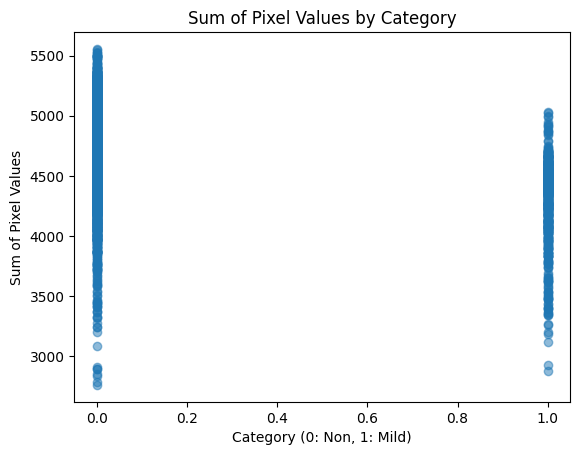

In [30]:
# 모든 픽셀 값을 더하는 함수
def sum_pixel_values(image_array):
    return np.sum(image_array, axis=(1, 2))

# 정상 데이터와 경증 데이터에 대해 모든 픽셀 값의 합 계산
Non_pixel_sums = sum_pixel_values(numpy_array_Non)
Mild_pixel_sums = sum_pixel_values(numpy_array_Mild)

# X 값 (Non: 0, Mild: 1)과 Y 값 (모든 픽셀의 합) 설정
X_values = np.concatenate([np.zeros(len(Non_pixel_sums)), np.ones(len(Mild_pixel_sums))])
Y_values = np.concatenate([Non_pixel_sums, Mild_pixel_sums])

# 2차원 시각화
plt.scatter(X_values, Y_values, alpha=0.5)
plt.xlabel('Category (0: Non, 1: Mild)')
plt.ylabel('Sum of Pixel Values')
plt.title('Sum of Pixel Values by Category')
plt.show()

역시나 그냥 모든 더한 값들을 시각화 한다면 군집을 만드는게 불가능함

그래서 변수 1개씩 보기 위해 모든 더한 값을 X, X의 제곱을 Y로 정하고 시각화를 실행

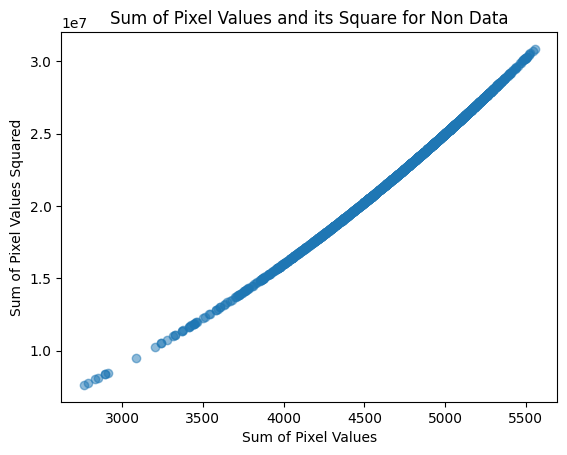

In [31]:
def sum_pixel_values(image_array):
    return np.sum(image_array, axis=(1, 2))

# 정상 데이터에 대해 모든 픽셀 값의 합 계산
Non_pixel_sums = sum_pixel_values(numpy_array_Non)

# X 값 (모든 픽셀의 합)과 Y 값 (모든 픽셀의 합의 제곱) 설정
X_values = Non_pixel_sums
Y_values = np.square(Non_pixel_sums)

# 2차원 시각화
plt.scatter(X_values, Y_values, alpha=0.5)
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Sum of Pixel Values Squared')
plt.title('Sum of Pixel Values and its Square for Non Data')
plt.show()

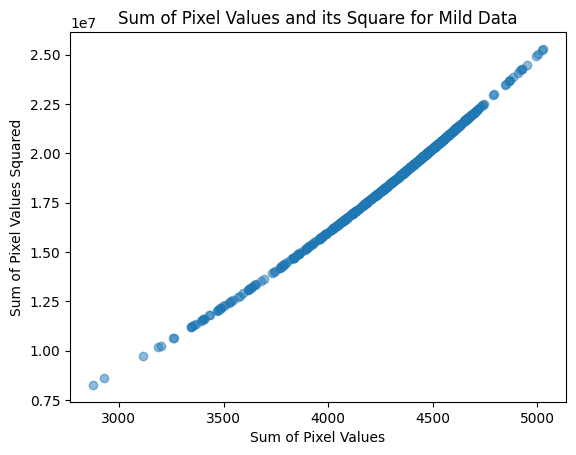

In [32]:
# Non 데이터 경로를 사용하여 넘파이 배열 생성
numpy_array_Mild = images_to_numpy(Mild_image_paths)

# 모든 픽셀 값을 더하는 함수
def sum_pixel_values(image_array):
    return np.sum(image_array, axis=(1, 2))

# 정상 데이터에 대해 모든 픽셀 값의 합 계산
Mild_pixel_sums = sum_pixel_values(numpy_array_Mild)

# X 값 (모든 픽셀의 합)과 Y 값 (모든 픽셀의 합의 제곱) 설정
X_values = Mild_pixel_sums
Y_values = np.square(Mild_pixel_sums)

# 2차원 시각화
plt.scatter(X_values, Y_values, alpha=0.5)
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Sum of Pixel Values Squared')
plt.title('Sum of Pixel Values and its Square for Mild Data')
plt.show()


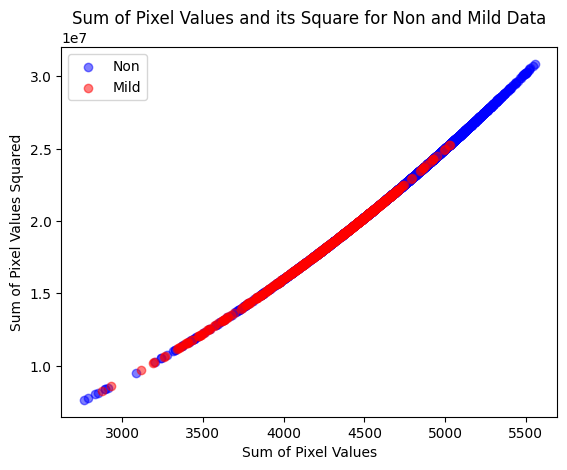

In [33]:
# 모든 픽셀 값을 더하는 함수
def sum_pixel_values(image_array):
    return np.sum(image_array, axis=(1, 2))

# 정상 데이터에 대해 모든 픽셀 값의 합 계산
Non_pixel_sums = sum_pixel_values(numpy_array_Non)
Mild_pixel_sums = sum_pixel_values(numpy_array_Mild)

# X 값 (모든 픽셀의 합)과 Y 값 (모든 픽셀의 합의 제곱) 설정
X_values_Non = Non_pixel_sums
Y_values_Non = np.square(Non_pixel_sums)

X_values_Mild = Mild_pixel_sums
Y_values_Mild = np.square(Mild_pixel_sums)

# 2차원 시각화
plt.scatter(X_values_Non, Y_values_Non, alpha=0.5, label='Non', color='blue')
plt.scatter(X_values_Mild, Y_values_Mild, alpha=0.5, label='Mild', color='red')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Sum of Pixel Values Squared')
plt.title('Sum of Pixel Values and its Square for Non and Mild Data')
plt.legend()
plt.show()

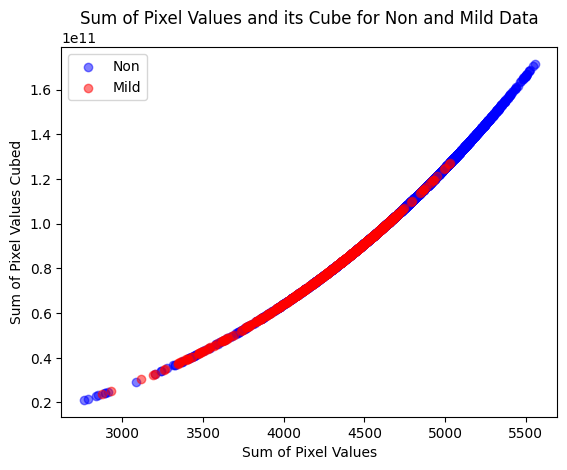

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# 모든 픽셀 값을 더하는 함수
def sum_pixel_values(image_array):
    return np.sum(image_array, axis=(1, 2))

# 정상 데이터에 대해 모든 픽셀 값의 합 계산
Non_pixel_sums = sum_pixel_values(numpy_array_Non)
Mild_pixel_sums = sum_pixel_values(numpy_array_Mild)

# X 값 (모든 픽셀의 합)과 Y 값 (모든 픽셀의 합의 3제곱) 설정
X_values_Non = Non_pixel_sums
Y_values_Non = np.power(Non_pixel_sums, 3)

X_values_Mild = Mild_pixel_sums
Y_values_Mild = np.power(Mild_pixel_sums, 3)

# 2차원 시각화
plt.scatter(X_values_Non, Y_values_Non, alpha=0.5, label='Non', color='blue')
plt.scatter(X_values_Mild, Y_values_Mild, alpha=0.5, label='Mild', color='red')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Sum of Pixel Values Cubed')
plt.title('Sum of Pixel Values and its Cube for Non and Mild Data')
plt.legend()
plt.show()


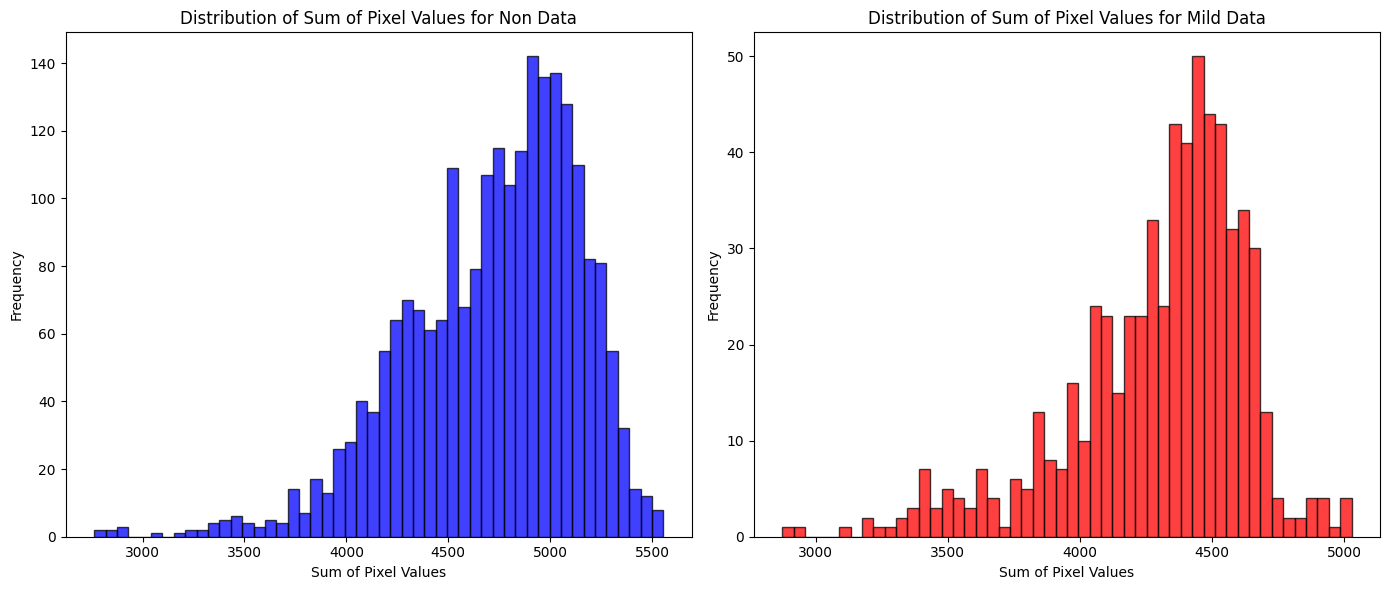

In [35]:

# 모든 픽셀 값을 더하는 함수
def sum_pixel_values(image_array):
    return np.sum(image_array, axis=(1, 2))

# 정상 데이터에 대해 모든 픽셀 값의 합 계산
Non_pixel_sums = sum_pixel_values(numpy_array_Non)
Mild_pixel_sums = sum_pixel_values(numpy_array_Mild)

# 히스토그램 시각화
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(Non_pixel_sums, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.title('Distribution of Sum of Pixel Values for Non Data')

plt.subplot(1, 2, 2)
plt.hist(Mild_pixel_sums, bins=50, alpha=0.75, color='red', edgecolor='black')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.title('Distribution of Sum of Pixel Values for Mild Data')

plt.tight_layout()
plt.show()


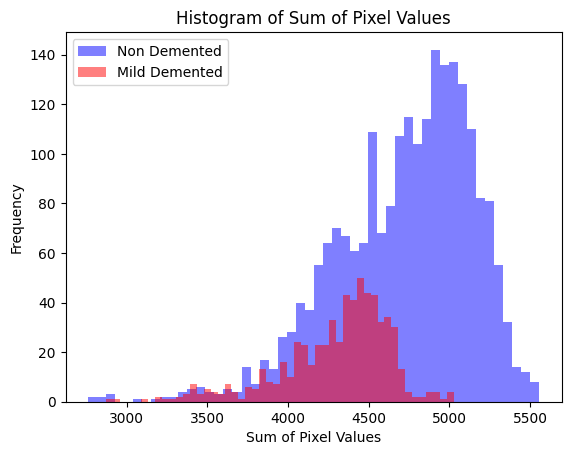

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# 두 데이터셋의 픽셀 값 합계 계산 함수
def sum_pixel_values(image_array):
    return np.sum(image_array, axis=(1, 2))

# Non 데이터의 픽셀 값 합계
Non_pixel_sums = sum_pixel_values(numpy_array_Non)
# Mild 데이터의 픽셀 값 합계
Mild_pixel_sums = sum_pixel_values(numpy_array_Mild)

# 히스토그램 시각화
plt.hist(Non_pixel_sums, bins=50, alpha=0.5, label='Non Demented', color='blue')
plt.hist(Mild_pixel_sums, bins=50, alpha=0.5, label='Mild Demented', color='red')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram of Sum of Pixel Values')
plt.legend()
plt.show()


# VAE로 증강한 데이터 시각화

In [37]:
import os
import numpy as np
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

# 이미지 파일 경로를 읽어오는 함수
def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

# 이미지를 넘파이 배열로 변환하는 함수
def images_to_numpy(images):
    image_arrays = [mpimg.imread(image_path) for image_path in images]
    return np.array(image_arrays)

# 'MRI_치매_데이터' 디렉토리 내의 각 카테고리에 대한 이미지 경로 리스트 생성
base_dir = '/home/eunzi/더더 빌리겠습미다/2024/논문/MRI_치매_데이터생성/'
Non_image_paths = read_images_from_path(os.path.join(base_dir, "Non_train+VAE_Non_e1000_random-vector_2"))
Mild_image_paths = read_images_from_path(os.path.join(base_dir, "Mild_train+VAE_Mild_e1000_random-vector_2"))

# 각 카테고리별로 이미지 경로 리스트를 분할
Non_train_paths, Non_test_paths = train_test_split(Non_image_paths, test_size=0.2, random_state=42)
Mild_train_paths, Mild_test_paths = train_test_split(Mild_image_paths, test_size=0.2, random_state=42)

# 분할된 이미지 경로를 사용하여 넘파이 배열 생성
numpy_array_Non = images_to_numpy(Non_train_paths)
numpy_array_Mild = images_to_numpy(Mild_train_paths)

# 넘파이 배열의 크기 확인
print("정상 데이터 크기:", numpy_array_Non.shape)
print("경증 데이터 크기:", numpy_array_Mild.shape)


정상 데이터 크기: (3632, 128, 128)
경증 데이터 크기: (1061, 128, 128)


# 이미지들의 모든 합들

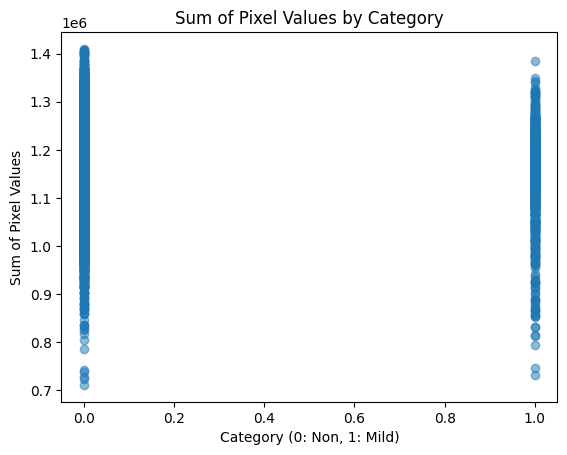

In [38]:
# 모든 픽셀 값을 더하는 함수
def sum_pixel_values(image_array):
    return np.sum(image_array, axis=(1, 2))

# 정상 데이터와 경증 데이터에 대해 모든 픽셀 값의 합 계산
Non_pixel_sums = sum_pixel_values(numpy_array_Non)
Mild_pixel_sums = sum_pixel_values(numpy_array_Mild)

# X 값 (Non: 0, Mild: 1)과 Y 값 (모든 픽셀의 합) 설정
X_values = np.concatenate([np.zeros(len(Non_pixel_sums)), np.ones(len(Mild_pixel_sums))])
Y_values = np.concatenate([Non_pixel_sums, Mild_pixel_sums])

# 2차원 시각화
plt.scatter(X_values, Y_values, alpha=0.5)
plt.xlabel('Category (0: Non, 1: Mild)')
plt.ylabel('Sum of Pixel Values')
plt.title('Sum of Pixel Values by Category')
plt.show()

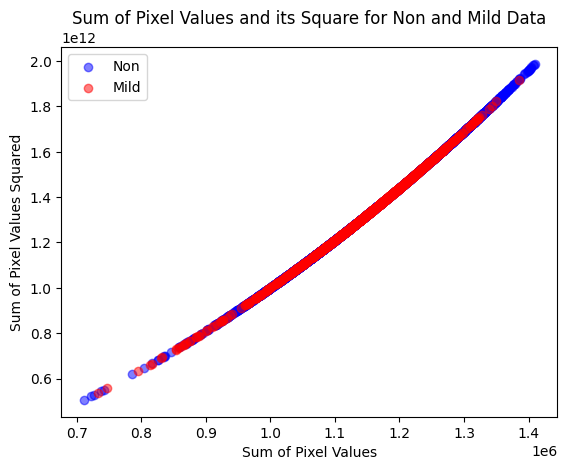

In [39]:
# 모든 픽셀 값을 더하는 함수
def sum_pixel_values(image_array):
    return np.sum(image_array, axis=(1, 2))

# 정상 데이터에 대해 모든 픽셀 값의 합 계산
Non_pixel_sums = sum_pixel_values(numpy_array_Non)
Mild_pixel_sums = sum_pixel_values(numpy_array_Mild)

# X 값 (모든 픽셀의 합)과 Y 값 (모든 픽셀의 합의 제곱) 설정
X_values_Non = Non_pixel_sums
Y_values_Non = np.square(Non_pixel_sums)

X_values_Mild = Mild_pixel_sums
Y_values_Mild = np.square(Mild_pixel_sums)

# 2차원 시각화
plt.scatter(X_values_Non, Y_values_Non, alpha=0.5, label='Non', color='blue')
plt.scatter(X_values_Mild, Y_values_Mild, alpha=0.5, label='Mild', color='red')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Sum of Pixel Values Squared')
plt.title('Sum of Pixel Values and its Square for Non and Mild Data')
plt.legend()
plt.show()

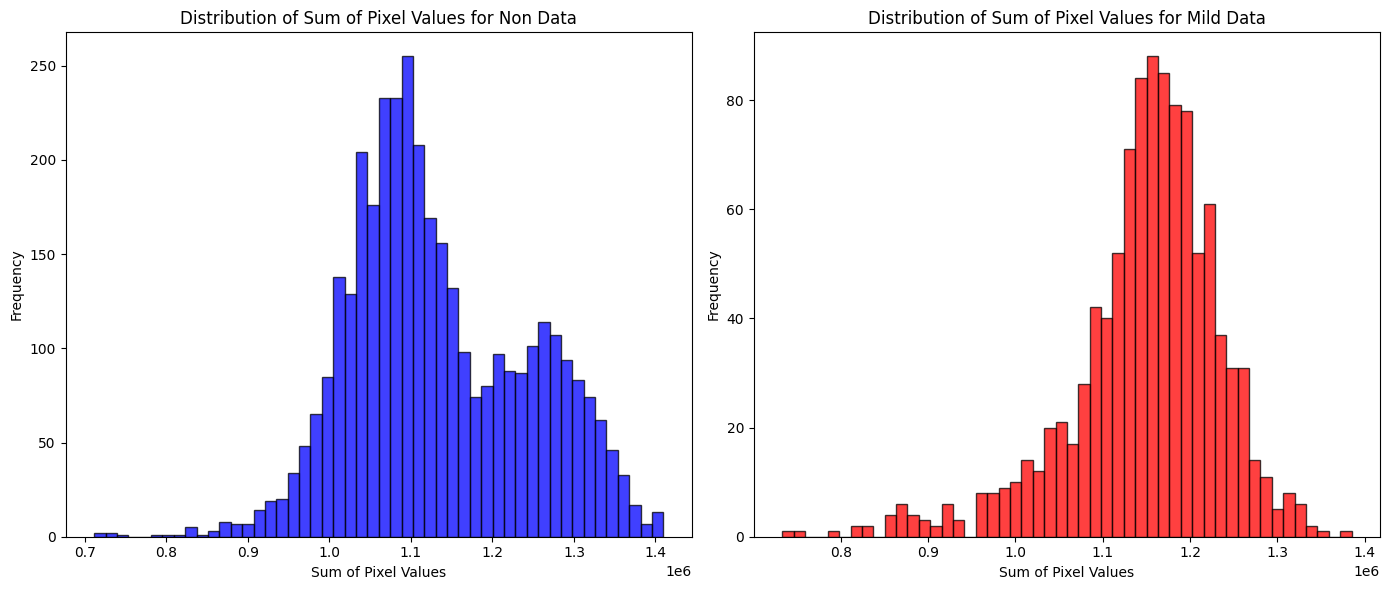

In [40]:

# 모든 픽셀 값을 더하는 함수
def sum_pixel_values(image_array):
    return np.sum(image_array, axis=(1, 2))

# 정상 데이터에 대해 모든 픽셀 값의 합 계산
Non_pixel_sums = sum_pixel_values(numpy_array_Non)
Mild_pixel_sums = sum_pixel_values(numpy_array_Mild)

# 히스토그램 시각화
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(Non_pixel_sums, bins=50, alpha=0.75, color='blue', edgecolor='black')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.title('Distribution of Sum of Pixel Values for Non Data')

plt.subplot(1, 2, 2)
plt.hist(Mild_pixel_sums, bins=50, alpha=0.75, color='red', edgecolor='black')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.title('Distribution of Sum of Pixel Values for Mild Data')

plt.tight_layout()
plt.show()


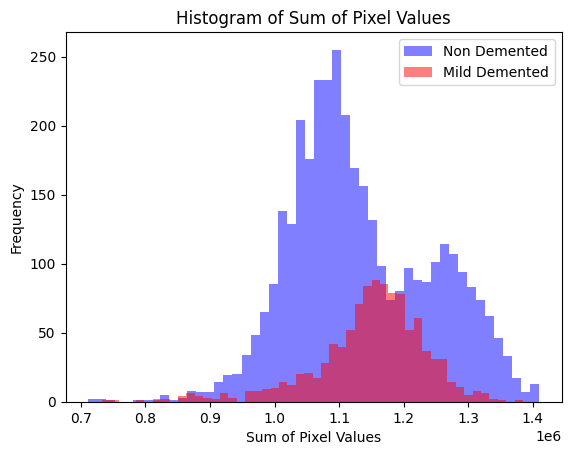

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# 두 데이터셋의 픽셀 값 합계 계산 함수
def sum_pixel_values(image_array):
    return np.sum(image_array, axis=(1, 2))

# Non 데이터의 픽셀 값 합계
Non_pixel_sums = sum_pixel_values(numpy_array_Non)
# Mild 데이터의 픽셀 값 합계
Mild_pixel_sums = sum_pixel_values(numpy_array_Mild)

# 히스토그램 시각화
plt.hist(Non_pixel_sums, bins=50, alpha=0.5, label='Non Demented', color='blue')
plt.hist(Mild_pixel_sums, bins=50, alpha=0.5, label='Mild Demented', color='red')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram of Sum of Pixel Values')
plt.legend()
plt.show()


# 1번째 디렉토리 정규화 and 시각화
    - 2번째 디렉토리 값도 정규화가 되어 있기 때문에 255로 나눠줌

In [91]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# from sklearn.model_selection import train_test_split

# # 이미지 파일 경로를 읽어오는 함수
# def read_images_from_path(path):
#     image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
#     images = [os.path.join(path, f) for f in image_files]
#     return images

# # 이미지를 넘파이 배열로 변환하는 함수
# def images_to_numpy(images):
#     image_arrays = [mpimg.imread(image_path) / 255.0 for image_path in images]  # 255로 나누어 전처리
#     return np.array(image_arrays)

# # 'MRI_치매_데이터' 디렉토리 내의 각 카테고리에 대한 이미지 경로 리스트 생성
# base_dir1 = '/home/eunzi/더더 빌리겠습미다/2024/논문/MRI_치매_데이터__/'
# Non_image_paths = read_images_from_path(os.path.join(base_dir1, "Non_Demented_train"))
# Mild_image_paths = read_images_from_path(os.path.join(base_dir1, "Mild_Demented_train"))

# # 각 카테고리별로 이미지 경로 리스트를 분할
# Non_train_paths, Non_test_paths = train_test_split(Non_image_paths, test_size=0.2, random_state=42)
# Mild_train_paths, Mild_test_paths = train_test_split(Mild_image_paths, test_size=0.2, random_state=42)

# # 분할된 이미지 경로를 사용하여 넘파이 배열 생성
# numpy_array_Non = images_to_numpy(Non_train_paths)
# numpy_array_Mild = images_to_numpy(Mild_train_paths)


# # 'MRI_치매_데이터생성' 디렉토리 내의 각 카테고리에 대한 이미지 경로 리스트 생성
# base_dir2 = '/home/eunzi/더더 빌리겠습미다/2024/논문/MRI_치매_데이터생성/'
# VAE_Non_image_paths = read_images_from_path(os.path.join(base_dir2, "Non_train+VAE_Non_e1000_random-vector_2"))
# VAE_Mild_image_paths = read_images_from_path(os.path.join(base_dir2, "Mild_train+VAE_Mild_e1000_random-vector_2"))

# # 각 카테고리별로 이미지 경로 리스트를 분할
# VAE_Non_train_paths, VAE_Non_test_paths = train_test_split(VAE_Non_image_paths, test_size=0.2, random_state=42)
# VAE_Mild_train_paths, VAE_Mild_test_paths = train_test_split(VAE_Mild_image_paths, test_size=0.2, random_state=42)

# # 분할된 이미지 경로를 사용하여 넘파이 배열 생성
# VAE_numpy_array_Non = images_to_numpy(VAE_Non_train_paths)
# VAE_numpy_array_Mild = images_to_numpy(VAE_Mild_train_paths)

# # 모든 픽셀 값을 더하는 함수
# def sum_pixel_values(image_array):
#     return np.sum(image_array, axis=(1, 2))

# # 정상 데이터와 경증 데이터에 대해 모든 픽셀 값의 합 
# #계산
# Non_pixel_sums = sum_pixel_values(numpy_array_Non)
# Mild_pixel_sums = sum_pixel_values(numpy_array_Mild)
# VAE_Non_pixel_sums = sum_pixel_values(VAE_numpy_array_Non)
# VAE_Mild_pixel_sums = sum_pixel_values(VAE_numpy_array_Mild)


In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split

# 이미지 파일 경로를 읽어오는 함수
def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

# 이미지를 넘파이 배열로 변환하는 함수
def images_to_numpy(images):
    image_arrays = [mpimg.imread(image_path) / 255.0 for image_path in images]  # 255로 나누어 전처리
    return np.array(image_arrays)

# 'MRI_치매_데이터' 디렉토리 내의 각 카테고리에 대한 이미지 경로 리스트 생성
base_dir1 = '/home/eunzi/더더 빌리겠습미다/2024/논문/MRI_치매_데이터__/'
Non_image_paths1 = read_images_from_path(os.path.join(base_dir1, "Non_Demented_train"))
Mild_image_paths1 = read_images_from_path(os.path.join(base_dir1, "Mild_Demented_train"))

# Non 데이터 경로를 사용하여 넘파이 배열 생성
numpy_array_Non1 = images_to_numpy(Non_image_paths1)
numpy_array_Mild1 = images_to_numpy(Mild_image_paths1)

# 'MRI_치매_데이터생성' 디렉토리 내의 각 카테고리에 대한 이미지 경로 리스트 생성
base_dir2 = '/home/eunzi/더더 빌리겠습미다/2024/논문/MRI_치매_데이터생성/'
Non_image_paths2 = read_images_from_path(os.path.join(base_dir2, "Non_train+VAE_Non_e1000_random-vector_2"))
Mild_image_paths2 = read_images_from_path(os.path.join(base_dir2, "Mild_train+VAE_Mild_e1000_random-vector_2"))

# 각 카테고리별로 이미지 경로 리스트를 분할
Non_train_paths, Non_test_paths = train_test_split(Non_image_paths2, test_size=0.2, random_state=42)
Mild_train_paths, Mild_test_paths = train_test_split(Mild_image_paths2, test_size=0.2, random_state=42)

# 분할된 이미지 경로를 사용하여 넘파이 배열 생성
numpy_array_Non2 = images_to_numpy(Non_train_paths)
numpy_array_Mild2 = images_to_numpy(Mild_train_paths)

# 모든 픽셀 값을 더하는 함수
def sum_pixel_values(image_array):
    return np.sum(image_array, axis=(1, 2))

# 정상 데이터와 경증 데이터에 대해 모든 픽셀 값의 합 계산
Non_pixel_sums1 = sum_pixel_values(numpy_array_Non1)
Mild_pixel_sums1 = sum_pixel_values(numpy_array_Mild1)
Non_pixel_sums2 = sum_pixel_values(numpy_array_Non2)
Mild_pixel_sums2 = sum_pixel_values(numpy_array_Mild2)

# 정규화 함수
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# 분포 정규화
normalized_Non_pixel_sums1 = normalize(Non_pixel_sums1)  # 원본 데이터의 정상 데이터 정규화
normalized_Non_pixel_sums2 = normalize(Non_pixel_sums2)  # 증강된 데이터의 정상 데이터 정규화
normalized_Mild_pixel_sums1 = normalize(Mild_pixel_sums1)  # 원본 데이터의 경증 데이터 정규화
normalized_Mild_pixel_sums2 = normalize(Mild_pixel_sums2)  # 증강된 데이터의 경증 데이터 정규화

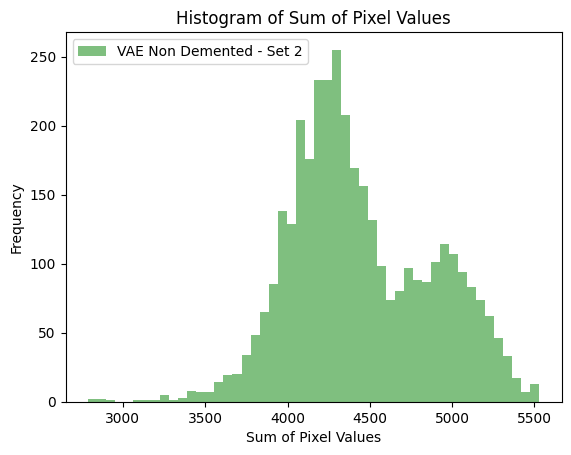

In [6]:
plt.hist(Non_pixel_sums2, bins=50, alpha=0.5, label='VAE Non Demented - Set 2', color='green')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram of Sum of Pixel Values')
plt.legend()
plt.show()

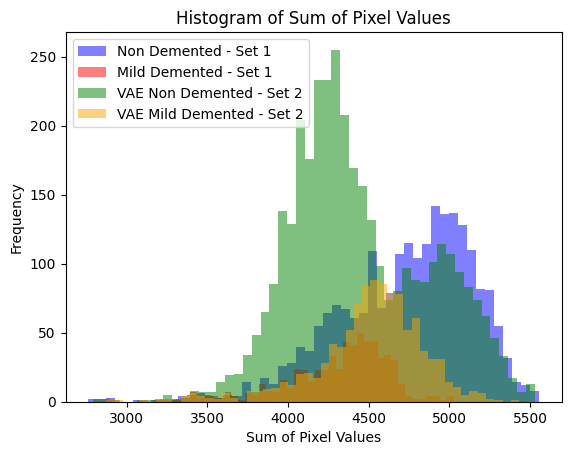

In [7]:
# 히스토그램 시각화
plt.hist(Non_pixel_sums1, bins=50, alpha=0.5, label='Non Demented - Set 1', color='blue')
plt.hist(Mild_pixel_sums1, bins=50, alpha=0.5, label='Mild Demented - Set 1', color='red')
plt.hist(Non_pixel_sums2, bins=50, alpha=0.5, label='VAE Non Demented - Set 2', color='green')
plt.hist(Mild_pixel_sums2, bins=50, alpha=0.5, label='VAE Mild Demented - Set 2', color='orange')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram of Sum of Pixel Values')
plt.legend()
plt.show()

### 그냥 Non 데이터와 VAE로 증강한 데이터

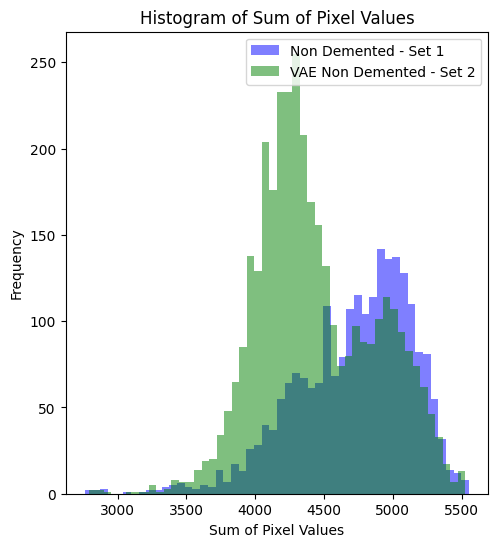

In [9]:
# 히스토그램 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(Non_pixel_sums1, bins=50, alpha=0.5, label='Non Demented - Set 1', color='blue')
plt.hist(Non_pixel_sums2, bins=50, alpha=0.5, label='VAE Non Demented - Set 2', color='green')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram of Sum of Pixel Values')
plt.legend()
plt.show()

### 그냥 Mild 데이터와 VAE로 증강한 데이터

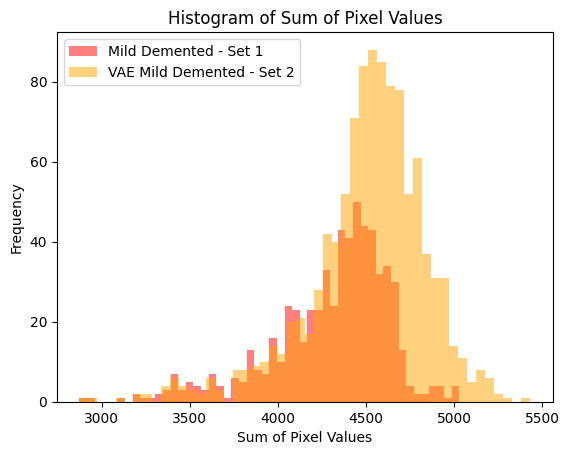

In [10]:
plt.hist(Mild_pixel_sums1, bins=50, alpha=0.5, label='Mild Demented - Set 1', color='red')
plt.hist(Mild_pixel_sums2, bins=50, alpha=0.5, label='VAE Mild Demented - Set 2', color='orange')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.title('Histogram of Sum of Pixel Values')
plt.legend()
plt.show()

2024.05.22

Non을 VAE로 증강하여 생성된 데이터들은 기존의 분포와 완전히 다른 분포가 되었음.

Mild는 기존의 분포에서 별로 크게 차이가 나는 분포가 아니게 되었음.


BUT 수상한 점이 있음. 바로 VAE Non data의 증강 결과임. CNN을 통해 F1_Score이 99%가 나왔는데, 이상하게 성능이 더 좋아졌다는 것임. 그리고 두 분포의 거리가 그렇게 차이가 나지 않음. 
    
- 이는 이 두 분포에서 경증과 정상의 차이가 나온다는 것을 알 수 있다? 

    - 근데 잘 모르겠음. 왜냐하면 저기서 나온 픽셀의 합들이 노이즈가 껴서 오류가 나는 것이라면 위의 말을 그대로 말할 수 없음.
    
1. 그렇다면 random vector 값을 사용하지 않고, real-data-vector의 값을 사용한 증강 이미지로 CNN을 돌려서 위의 분포 그대로 나오는지 확인하자.
  
2. Non의 데이터는 증강 없이 돌리고, Mild 데이터는 VAE로 증강된 결과를 가지고 코드를 돌려서 99% 이상이 언제 나오는지 확인을 하자.
    - 근데 얘를 하려면 몇 에포크에서 성능이 좋아졌는지를 확인해 보아야 하기 때문에 더 많은 고민이 필요해 보인다.

결론

위 증강의 결과가 노이즈의 영향을 받지 않고, 사실이라면, Mild는 무언가 삭제시키는 것이 아닐 수도 있다. 오히려 종양 같이 뇌에 오류가 늘어나는 것일 지도 모른다.


취소 취소 이상한 이유는 노이즈 때문이에욥 -> 그러나 노이즈 때문이라면, Mild도 같이 줄어들거나 Non도 늘어나야 하는데 분포의 방향이 서로 다름!

# 증강한 데이터에서 일부 데이터가 안보이는 이유?

- 2번의 분포에서 정상과 정상 증강한 결과를 비교하는데서도 같은 궁금증이 있었음

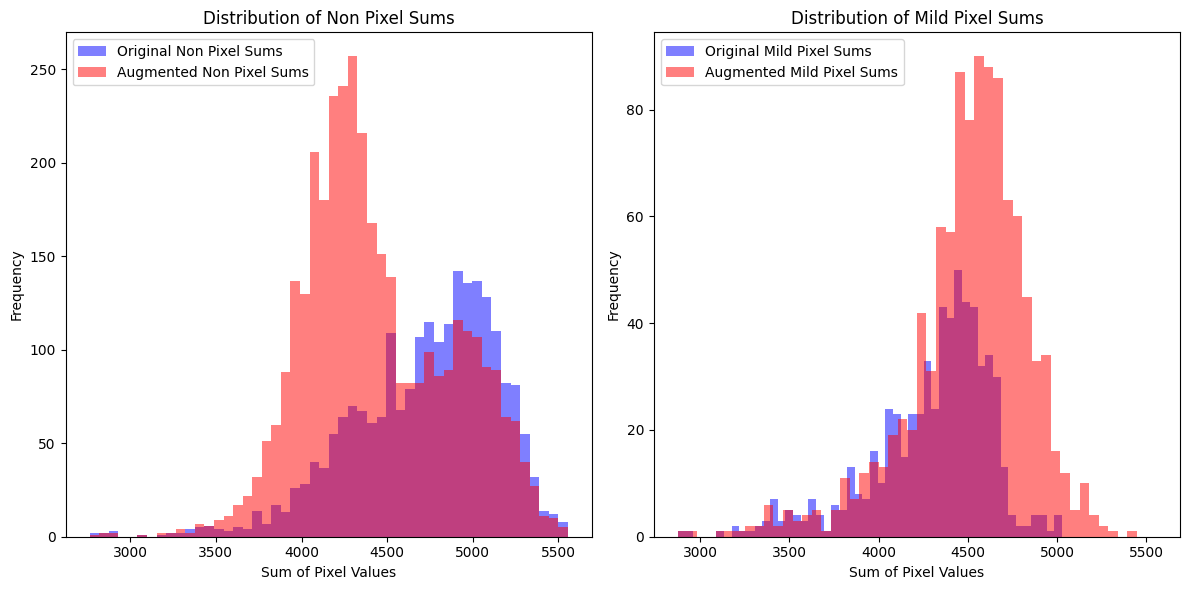

In [11]:
# 히스토그램 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(Non_pixel_sums1, bins=bin_edges_Non1, alpha=0.5, label='Original Non Pixel Sums', color='blue')
plt.hist(Non_pixel_sums2, bins=bin_edges_Non2, alpha=0.5, label='Augmented Non Pixel Sums', color='red')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.title('Distribution of Non Pixel Sums')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(Mild_pixel_sums1, bins=bin_edges_Mild1, alpha=0.5, label='Original Mild Pixel Sums', color='blue')
plt.hist(Mild_pixel_sums2, bins=bin_edges_Mild2, alpha=0.5, label='Augmented Mild Pixel Sums', color='red')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.title('Distribution of Mild Pixel Sums')
plt.legend()

plt.tight_layout()
plt.show()

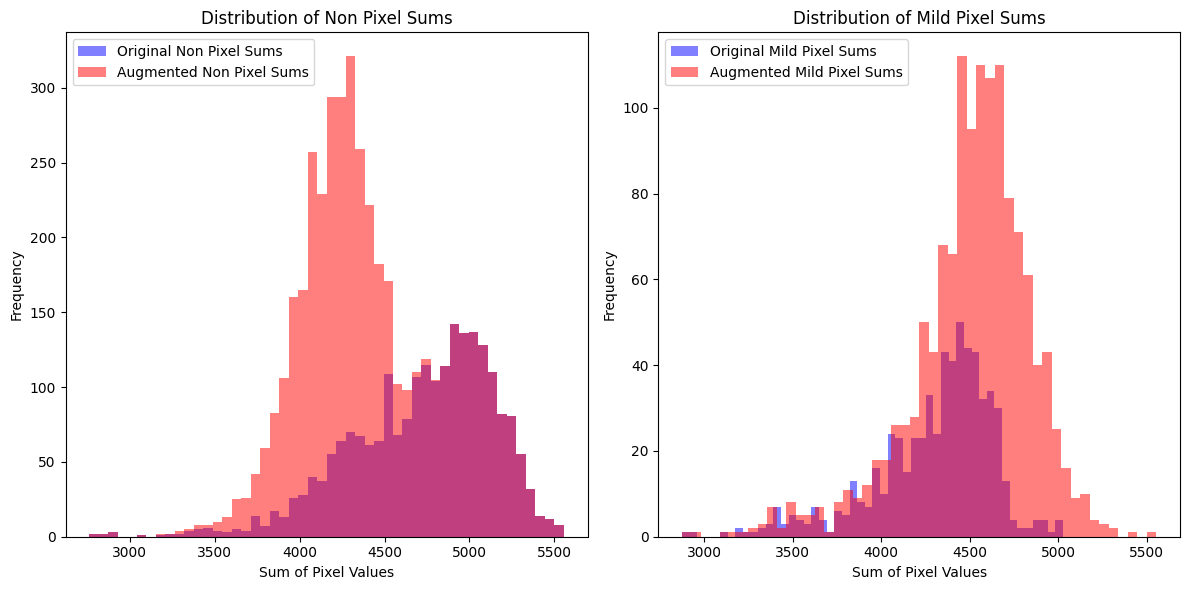

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from scipy.special import rel_entr

# 이미지 파일 경로를 읽어오는 함수
def read_images_from_path(path):
    image_files = [f for f in os.listdir(path) if f.endswith(".jpg")]
    images = [os.path.join(path, f) for f in image_files]
    return images

# 이미지를 넘파이 배열로 변환하는 함수
def images_to_numpy(images):
    image_arrays = [mpimg.imread(image_path) / 255.0 for image_path in images]  # 255로 나누어 전처리
    return np.array(image_arrays)

# 'MRI_치매_데이터' 디렉토리 내의 각 카테고리에 대한 이미지 경로 리스트 생성
base_dir1 = '/home/eunzi/더더 빌리겠습미다/2024/논문/MRI_치매_데이터__/'
Non_image_paths1 = read_images_from_path(os.path.join(base_dir1, "Non_Demented_train"))
Mild_image_paths1 = read_images_from_path(os.path.join(base_dir1, "Mild_Demented_train"))

# Non 데이터 경로를 사용하여 넘파이 배열 생성
numpy_array_Non1 = images_to_numpy(Non_image_paths1)
numpy_array_Mild1 = images_to_numpy(Mild_image_paths1)

# 'MRI_치매_데이터생성' 디렉토리 내의 각 카테고리에 대한 이미지 경로 리스트 생성
base_dir2 = '/home/eunzi/더더 빌리겠습미다/2024/논문/MRI_치매_데이터생성/'
Non_image_paths2 = read_images_from_path(os.path.join(base_dir2, "Non_train+VAE_Non_e1000_random-vector_2"))
Mild_image_paths2 = read_images_from_path(os.path.join(base_dir2, "Mild_train+VAE_Mild_e1000_random-vector_2"))

# 증강된 데이터 경로를 사용하여 넘파이 배열 생성
numpy_array_Non2 = images_to_numpy(Non_image_paths2)
numpy_array_Mild2 = images_to_numpy(Mild_image_paths2)

# 모든 픽셀 값을 더하는 함수
def sum_pixel_values(image_array):
    return np.sum(image_array, axis=(1, 2))

# 정상 데이터와 경증 데이터에 대해 모든 픽셀 값의 합 계산
Non_pixel_sums1 = sum_pixel_values(numpy_array_Non1)
Mild_pixel_sums1 = sum_pixel_values(numpy_array_Mild1)
Non_pixel_sums2 = sum_pixel_values(numpy_array_Non2)
Mild_pixel_sums2 = sum_pixel_values(numpy_array_Mild2)

# 히스토그램을 사용하여 동일한 구간(bin)으로 분포 계산
def compute_histogram(data, bins=50):
    hist, bin_edges = np.histogram(data, bins=bins)
    return hist, bin_edges

# 각 데이터셋에 대해 히스토그램 계산
hist_Non1, bin_edges_Non1 = compute_histogram(Non_pixel_sums1)
hist_Non2, bin_edges_Non2 = compute_histogram(Non_pixel_sums2)
hist_Mild1, bin_edges_Mild1 = compute_histogram(Mild_pixel_sums1)
hist_Mild2, bin_edges_Mild2 = compute_histogram(Mild_pixel_sums2)

# 히스토그램 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(Non_pixel_sums1, bins=bin_edges_Non1, alpha=0.5, label='Original Non Pixel Sums', color='blue')
plt.hist(Non_pixel_sums2, bins=bin_edges_Non2, alpha=0.5, label='Augmented Non Pixel Sums', color='red')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.title('Distribution of Non Pixel Sums')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(Mild_pixel_sums1, bins=bin_edges_Mild1, alpha=0.5, label='Original Mild Pixel Sums', color='blue')
plt.hist(Mild_pixel_sums2, bins=bin_edges_Mild2, alpha=0.5, label='Augmented Mild Pixel Sums', color='red')
plt.xlabel('Sum of Pixel Values')
plt.ylabel('Frequency')
plt.title('Distribution of Mild Pixel Sums')
plt.legend()

plt.tight_layout()
plt.show()


위 코드와 아래 코드의 시각화 결과의 차이가 나는 이유?

위의 코드에서는 VAE로 증강한 결과 중 80%를 차지하는 Train Data와 모든 데이터가 그대로 있는 그냥 데이터를 함께 보았기 때문에 위와 같은 문제가 있었음


해결책

Train과 Test로 나누지 않고 시각화를 진행하면 문제가 없음